# **Import Required Libraries**

In [1]:
import os
import zipfile
import random
import cv2
import tifffile as tiff
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# **Data Preparation**

In [2]:
zip_path = '/content/satalite data.zip'
path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path)

dataset_path = '/content/data'
dataset_dir = os.listdir(dataset_path)

In [3]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

mask_dir = dataset_path + '/labels'
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

print("Total images before filtering:", len(images))
print("Total masks before filtering:", len(masks))

Total images before filtering: 306
Total masks before filtering: 306


# **Data Normalization (Per-Channel Normalization)**

In [4]:
def standardize_image(image):
    image = np.transpose(image, (2, 0, 1))

    normalized_image = np.zeros_like(image, dtype=np.float32)

    num_channels = image.shape[0]
    for i in range(num_channels):
        band = image[i]
        mean = np.mean(band)
        std = np.std(band)

        if std > 0:
            normalized_image[i] = (band - mean) / std
        else:
            normalized_image[i] = band

    return normalized_image

normalized_images = [standardize_image(img) for img in images]

print("Total normalized images:", len(normalized_images))

Total normalized images: 306


In [5]:
normalized_images[0].shape

(12, 128, 128)

# **Data Visualization**

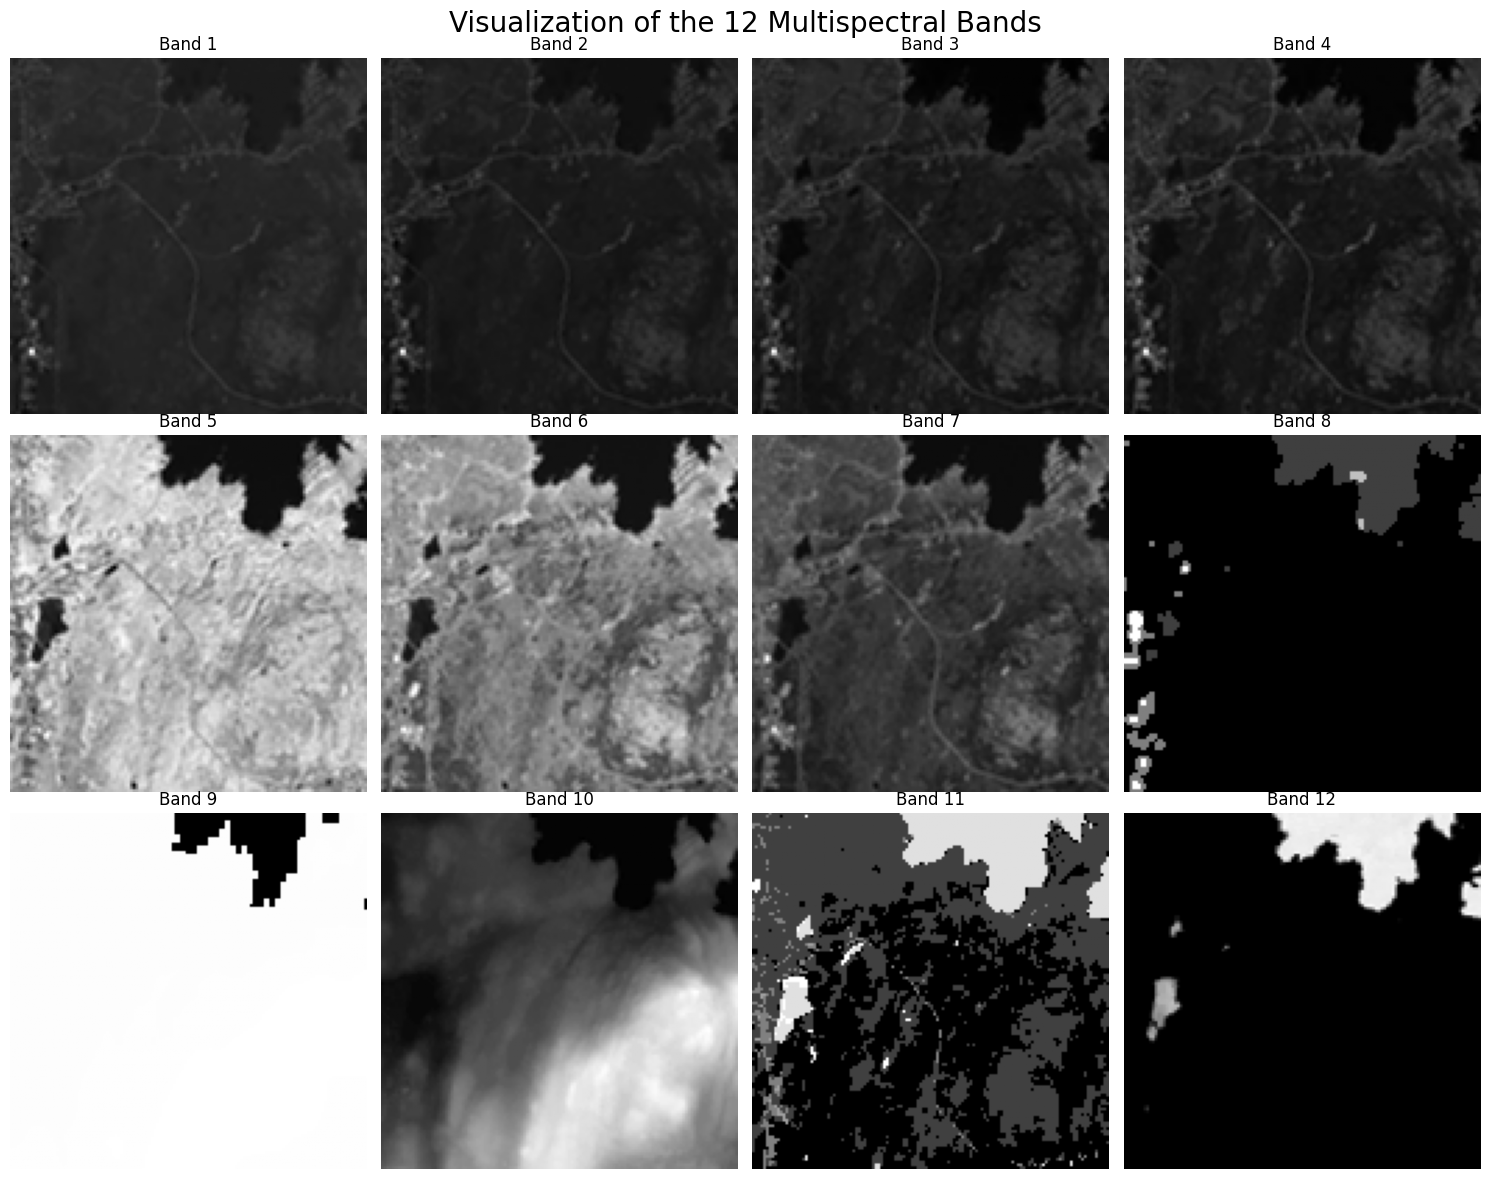

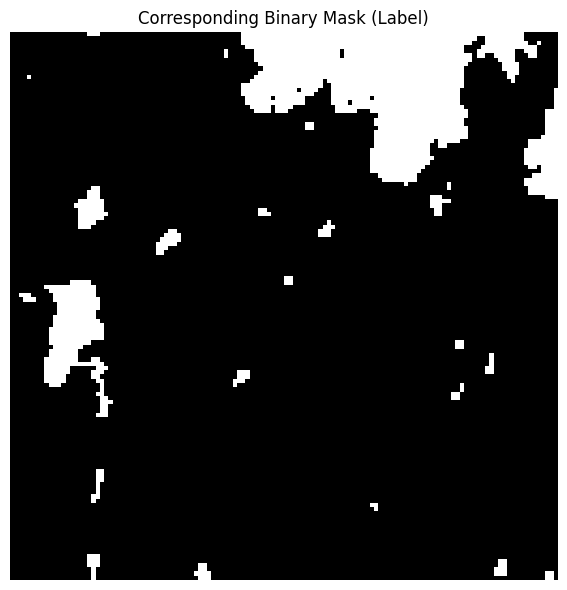

In [6]:
example_image = normalized_images[125]
example_mask = masks[125]

num_bands = example_image.shape[0]
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.suptitle('Visualization of the 12 Multispectral Bands', fontsize=20)

for i, ax in enumerate(axes.flat):
    if i < num_bands:
        ax.imshow(example_image[i], cmap='gray')
        ax.set_title(f'Band {i + 1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(example_mask, cmap='gray')
plt.title('Corresponding Binary Mask (Label)')
plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Architecture and Training**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import numpy as np

X = np.transpose(normalized_images, (0, 2, 3, 1))

y = np.expand_dims(masks, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (244, 128, 128, 12)
y_train shape: (244, 128, 128, 1)
X_test shape: (62, 128, 128, 12)
y_test shape: (62, 128, 128, 1)


In [8]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3,3), activation="relu", padding="same")(p3)
    c4 = Conv2D(256, (3,3), activation="relu", padding="same")(c4)

    # Decoder
    u5 = UpSampling2D((2,2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3,3), activation="relu", padding="same")(u5)
    c5 = Conv2D(128, (3,3), activation="relu", padding="same")(c5)

    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3,3), activation="relu", padding="same")(u6)
    c6 = Conv2D(64, (3,3), activation="relu", padding="same")(c6)

    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3,3), activation="relu", padding="same")(u7)
    c7 = Conv2D(32, (3,3), activation="relu", padding="same")(c7)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 1,949,473 (7.44 MB)

 Trainable params: 1,949,473 (7.44 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_test, y_test))

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7064 - loss: 15.0620 - val_accuracy: 0.7747 - val_loss: 0.5302
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7693 - loss: 2.0021 - val_accuracy: 0.8556 - val_loss: 0.4439
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8243 - loss: 0.4681 - val_accuracy: 0.8743 - val_loss: 0.3777
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8781 - loss: 0.3757 - val_accuracy: 0.8641 - val_loss: 0.3512
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8696 - loss: 0.3615 - val_accuracy: 0.8879 - val_loss: 0.3025
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8770 - loss: 0.3299 - val_accuracy: 0.8931 - val_loss: 0.2794
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8851 - loss: 0.3049 - val_accuracy: 0.9015 - val_loss: 0.2531
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8923 - loss: 0.2804 - val_accuracy: 0.9063 - val_loss: 

# **Evaluation(IoU, precision, recall, and F1-score)**

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

y_pred_probs = model.predict(X_test, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)

y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

iou = jaccard_score(y_true_flat, y_pred_flat, average="binary")
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

print("Evaluation Metrics:")
print(f"IoU:       {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 827ms/step
Evaluation Metrics:
IoU:       0.7452
Precision: 0.9268
Recall:    0.7918
F1-score:  0.8540


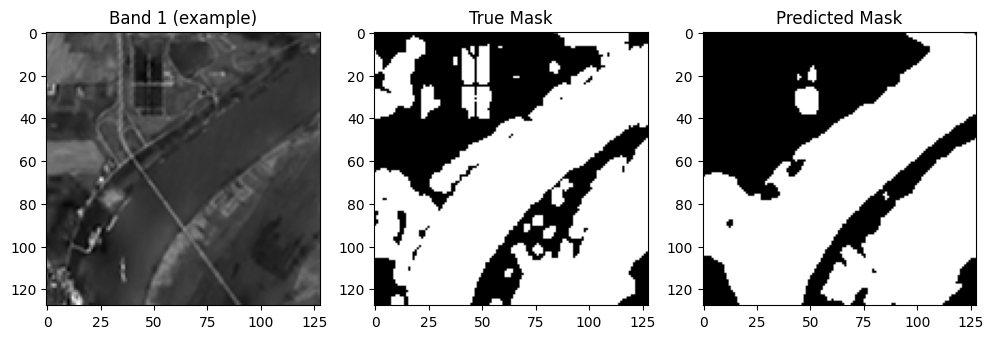

In [11]:
import random
idx = random.randint(0, len(X_test)-1)

pred_mask = y_pred[idx,:,:,0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[idx][:,:,0], cmap="gray"); plt.title("Band 1 (example)")
plt.subplot(1,3,2); plt.imshow(y_test[idx][:,:,0], cmap="gray"); plt.title("True Mask")
plt.subplot(1,3,3); plt.imshow(pred_mask, cmap="gray"); plt.title("Predicted Mask")
plt.show()